<a href="https://colab.research.google.com/github/adiban17/VEGA-Hackathon/blob/main/Alzheimers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the paths
train_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Alzhiemer - MRI Scan/train'
test_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Alzhiemer - MRI Scan/test'

# Create an ImageDataGenerator object for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=90,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images and labels, ensuring grayscale (1 color channel)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),   # Resize images to 128x128
    color_mode='rgb',   # Load as rgb
    class_mode='categorical',
    batch_size=32   # Default batch-size is 32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='rgb',   # Load as rgb
    class_mode='categorical'
)

Found 5119 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


Found classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Plotting 20 random images from each class...


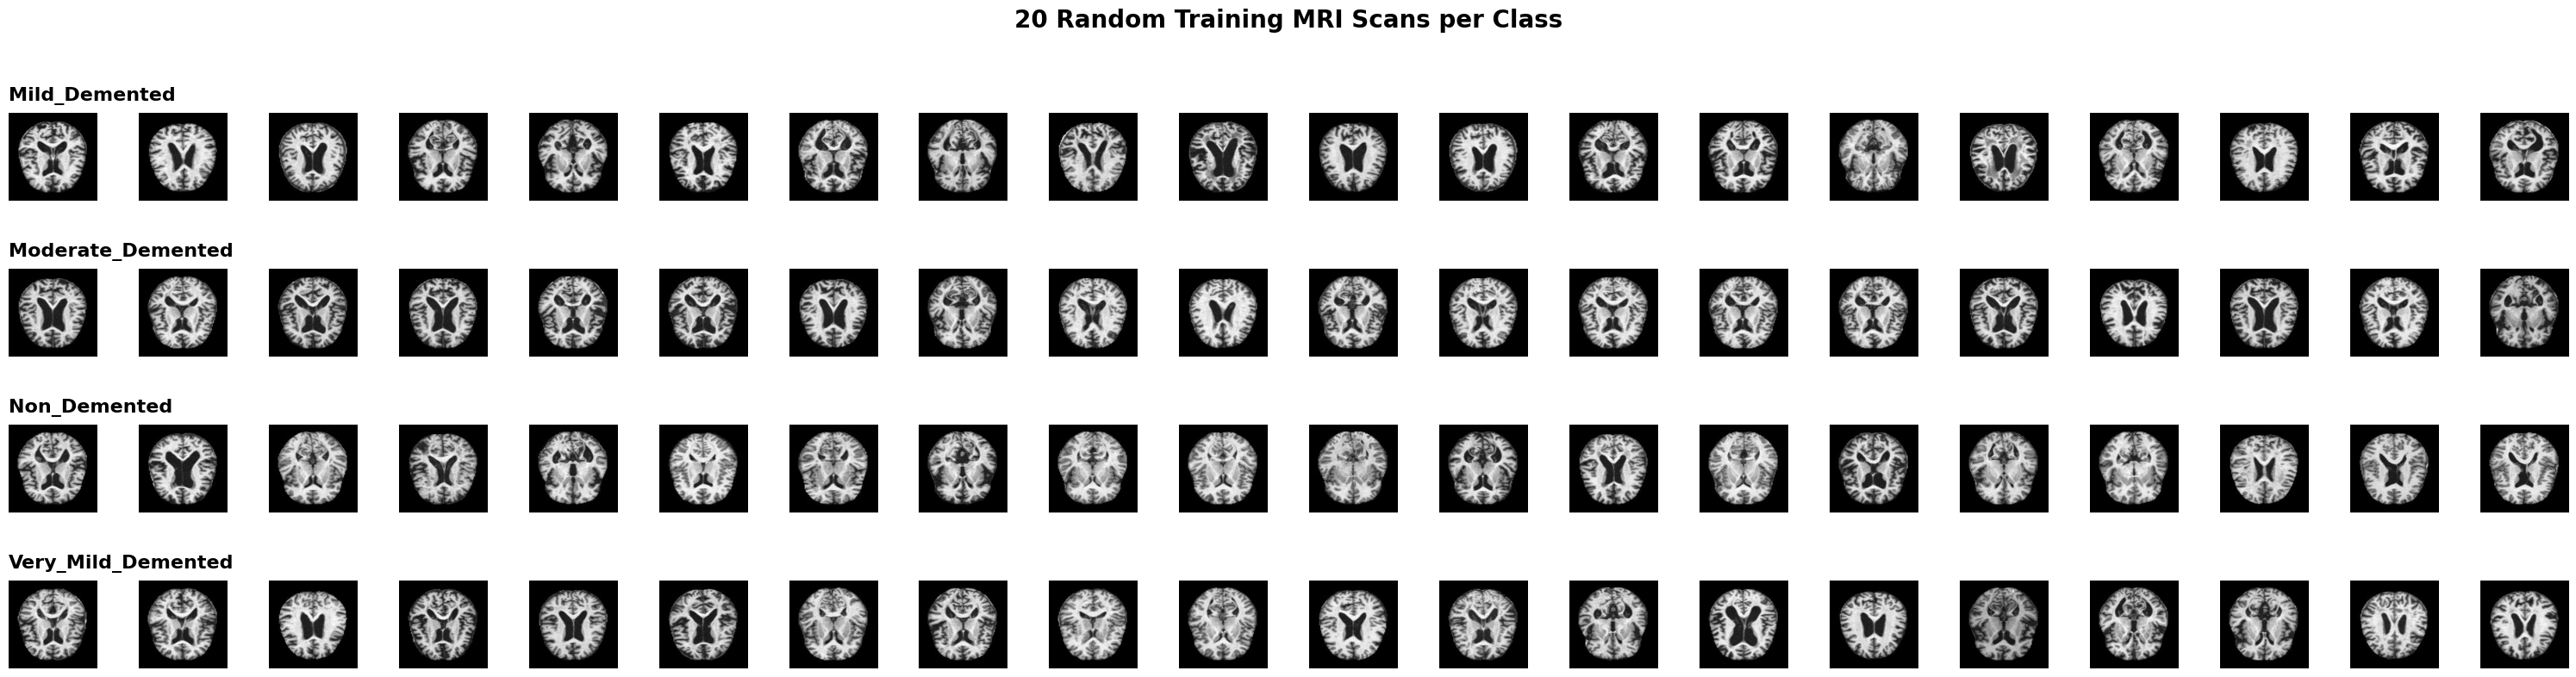

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Extract class names from your trained generator
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
images_per_class = 20

print(f"Found classes: {class_names}")
print("Plotting 20 random images from each class...")

# 2. Set up the matplotlib figure (Rows = Classes, Cols = 20)
# Making the figure wide enough to accommodate 20 images side-by-side
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(30, num_classes * 2))
fig.suptitle('20 Random Training MRI Scans per Class', fontsize=20, weight='bold', y=1.02)

# 3. Iterate through directories and plot
for i, class_name in enumerate(class_names):
    # Path to the specific class directory
    class_path = os.path.join(train_dir, class_name)

    # Get all image filenames in this class directory
    all_images = os.listdir(class_path)

    # Select random images (safeguarded in case a class has fewer than 20 images)
    selected_images = random.sample(all_images, min(images_per_class, len(all_images)))

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)

        # Read the image
        img = mpimg.imread(img_path)

        # Target the specific subplot axis
        ax = axes[i, j]

        # Display as grayscale (matching your generator settings)
        ax.imshow(img, cmap='grey')
        ax.axis('off') # Hide pixel axis numbers for a cleaner look

        # Add the class name above the very first image of each row
        if j == 0:
            ax.set_title(class_name, fontsize=16, weight='bold', loc='left', pad=10)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the pre-trained DenseNet121 model
# include_top=False removes the final classification layer so we can add our own
# weights='imagenet' uses the highly optimized pre-trained weights
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3) # Make sure your generator is set to 'rgb'!
)

# 2. Freeze the base model layers
# We don't want to destroy the pre-trained weights during initial training
for layer in base_model.layers:
    layer.trainable = False

# 3. Add our custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Condenses the feature maps
x = Dropout(0.5)(x) # Drops 50% of connections to prevent overfitting

# Note: 'num_classes' is from our previous visualization block.
# If you didn't run it, replace 'num_classes' with the actual integer (e.g., 4)
predictions = Dense(num_classes, activation='softmax')(x)

# 4. Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
# Using Adam optimizer with a slightly lower learning rate for stable transfer learning
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
model.summary()

Model compiled successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',      # Watch the validation loss
    patience=5,              # Wait 5 epochs without improvement before stopping
    restore_best_weights=True, # Automatically load the best weights when stopped
    verbose=1
)

checkpoint = ModelCheckpoint(
    # Saving directly back to your Hackathon Drive folder
    filepath='/content/drive/MyDrive/Vega Hackathon Dataset/best_alzheimer_densenet.keras',
    monitor='val_accuracy',  # Save based on the highest validation accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # Drop learning rate to 20% of its current value
    patience=3,              # Wait 3 epochs before dropping
    min_lr=1e-6,             # Don't let the learning rate go below this
    verbose=1
)

callbacks_list = [early_stop, checkpoint, reduce_lr]

# 2. Train the Model
epochs = 30 # We can set this high because EarlyStopping will catch it if it finishes early

print("Starting the training process...")

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks_list,
    verbose=1
)

print("Training complete! The best model has been saved.")

Starting the training process...
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4004 - loss: 2.0163
Epoch 1: val_accuracy improved from -inf to 0.52459, saving model to /content/drive/MyDrive/Vega Hackathon Dataset/best_alzheimer_densenet.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.4005 - loss: 2.0143 - val_accuracy: 0.5246 - val_loss: 1.0714 - learning_rate: 0.0010
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4656 - loss: 1.2332
Epoch 2: val_accuracy improved from 0.52459 to 0.53552, saving model to /content/drive/MyDrive/Vega Hackathon Dataset/best_alzheimer_densenet.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.4656 - loss: 1.2328 - val_accuracy: 0.5355 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4858 - loss: 1.0990
Epoch 3: val_accuracy did not improve from 0.53552
160/160 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.4858 - loss: 1.0989 - val_ac

## MedNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Shared MLP layers
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Avg Pool
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Max Pool
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    cbam_feature = layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    return layers.Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature):
    cbam_feature = channel_attention(cbam_feature)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import keras.ops as ops  # The modern way to handle tensor math in Keras

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = layers.Dense(channel // ratio, activation='relu', use_bias=True)
    shared_layer_two = layers.Dense(channel, use_bias=True)

    # Use Global Pooling Layers instead of raw TF reductions
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_two(shared_layer_one(avg_pool))

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_two(shared_layer_one(max_pool))

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    # Fix: Use keras.ops for reductions instead of tf.reduce_mean/max
    avg_pool = ops.mean(input_feature, axis=-1, keepdims=True)
    max_pool = ops.max(input_feature, axis=-1, keepdims=True)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    cbam_feature = layers.Conv2D(filters=1, kernel_size=7, padding='same',
                                 activation='sigmoid', use_bias=False)(concat)

    return layers.Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature):
    cbam_feature = channel_attention(cbam_feature)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

In [ ]:
def build_mednet(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Using MobileNetV2 as a lightweight backbone
    base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights='imagenet',
                                                   input_tensor=inputs)

    # Stop at the last convolutional output
    x = base_model.output

    # Apply Attention
    x = cbam_block(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name="MedNet_Alzheimer")
    return model

# This should now run without the KerasTensor error
model = build_mednet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "MedNet_Alzheimer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,998,086 (11.44 MB)

 Trainable params: 2,963,974 (11.31 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
import tensorflow as tf

# Standard MRI size is often 224 or 176
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Vega Hackathon Dataset/Alzhiemer - MRI Scan/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Since we use CategoricalCrossentropy
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Vega Hackathon Dataset/Alzhiemer - MRI Scan/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Optimization for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5119 files belonging to 4 classes.
Found 5119 files belonging to 4 classes.


In [ ]:
import numpy as np
from sklearn.utils import class_weight

# Extract labels to calculate weights
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_train_indices = np.argmax(y_train, axis=1)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)
class_weights = dict(enumerate(weights))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for medical precision
callbacks = [
    # Stop if validation loss doesn't improve for 5 epochs
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    # Lower LR if the model plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Compile with a low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1438s 9s/step - accuracy: 0.4913 - auc: 0.7713 - loss: 1.1842 - val_accuracy: 0.5054 - val_auc: 0.8047 - val_loss: 1.0164 - learning_rate: 1.0000e-04
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1443s 9s/step - accuracy: 0.6306 - auc: 0.8771 - loss: 0.6230 - val_accuracy: 0.3798 - val_auc: 0.7603 - val_loss: 1.0887 - learning_rate: 1.0000e-04
Epoch 3/50
 85/160 ━━━━━━━━━━━━━━━━━━━━ 8:58 7s/step - accuracy: 0.8098 - auc: 0.9639 - loss: 0.3106

KeyboardInterrupt: 